In [1]:
# Settings
import pickle
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import scispacy
import spacy
from functools import reduce
import swifter
import sys
from spacy import displacy
import en_ner_bc5cdr_md
from matplotlib import pyplot as plt
from spacy import displacy
from matplotlib import colors
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')

In [2]:
# Load WV
filename = '/home/mimic/Downloads/BioWordVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin'
wv_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [3]:
# Load NLP
nlp_model = en_ner_bc5cdr_md.load()
file_code = 'bc5cdr'

# WV Code block
```
from gensim.models import KeyedVectors

filename = '/home/mimic/Downloads/BioWordVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin'
wv_model = KeyedVectors.load_word2vec_format(filename, binary=True)
word = ""
wv_model.get_vector(word.lower())
```

In [4]:
# Text
train_data_path = '/home/mimic/Data/NOTEEVENTS_all_fold0/train_notes_seq.pickle'
val_data_path = '/home/mimic/Data/NOTEEVENTS_all_fold0/val_notes_seq.pickle'
test_data_path = '/home/mimic/Data/NOTEEVENTS_all_fold0/test_notes_seq.pickle'

with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)
    
with open(val_data_path, 'rb') as f:
    val_data = pickle.load(f)

with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

In [3]:
match_list = ['CHIEF COMPLAINT:',
'History of Present Illness:',
'Past Medical History:',
'Social History:',
'Family History:',
'Physical Exam:',
'Pertinent Results:',
'Brief Hospital Course:',
'Discharge Medication:',
'Discharge Diagnosis:',
'Discharge Condition:',
'Followup Instructions:',
'PAST MEDICAL HISTORY:'
'MEDICATIONS ON ADMISSION:',
'DISCHARGE CONDITION:',
'DISCHARGE DIAGNOSES:',
'DISCHARGE MEDICATIONS:']
match_list = list(set([w.lower() for w in match_list]))  # matching을 위해 소문자로 변경, 중복 인원으로부터 리스트를 단순 병합하므로 unique 수행

def get_matched(text):
    text_split = text.split('\n\n')
    
    is_keep = False  # 저장해야하는 단락인지 구분
    for text_in in text_split:
        # match_list 키워드가 있는 경우에 저장, matching을 위해 소문자로 변경하고 원문 형태는 유지
        text_in_lower = text_in.lower()
        if any(match_key in text_in_lower  for match_key in match_list):
            is_keep = True  # match에 해당하는 단락이므로 저장
            continue
        else: 
            if ':' in text_in:  # match가 아닌 새로운 단락이므로 제거
                text_split.remove(text_in)
                is_keep = False  # 저장할 필요 없는 단락이므로 제거
            else:
                if is_keep:  # 저장할 단락인지 여부에 따라 저장하거나 제거
                    continue
                else:
                    text_split.remove(text_in)
    text = '\n\n'.join(text_split)
    unique_ner= set([str(ent).lower() for ent in nlp_model(text).ents])  # 향후 wv을 위해 소문자로 변경, wv모델이 소문자만 허용
    
    return unique_ner

def convert_to_vector_sum(word_list):
    vector_list = []
    for word in word_list:
        try:
            vector_list.append(wv_model.get_vector(word))
        except KeyError:
            continue
    vector_list = [0]  if len(vector_list) == 0 else vector_list # 낮은 확률도 빈 값이 가능, 빈 값은 0으로 조정
    return np.sum(vector_list, axis=0, dtype=np.float64)

def convert_to_vector_mean(word_list):
    vector_list = []
    for word in word_list:
        try:
            vector_list.append(wv_model.get_vector(word))
        except KeyError:
            continue
    vector_list = [0]  if len(vector_list) == 0 else vector_list # 낮은 확률도 빈 값이 가능, 빈 값은 0으로 조정
    return np.mean(vector_list, axis=0, dtype=np.float64)

In [6]:
%%time
total_data = pd.concat([train_data, val_data,  test_data])

CPU times: user 18.8 ms, sys: 11.3 ms, total: 30 ms
Wall time: 33.9 ms


In [7]:
%%time
text_df = total_data[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'TEXT']]\
    .groupby(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])\
    .agg('\n\n'.join)\
    .reset_index()

CPU times: user 330 ms, sys: 22.7 ms, total: 353 ms
Wall time: 359 ms


In [8]:
%%time
text_df['word_list'] = text_df['TEXT'].swifter.apply(lambda text: get_matched(text))
with open('/home/mimic/Data/pickle/text_df.pk', 'wb') as f:
    pickle.dump(text_df, f, pickle.HIGHEST_PROTOCOL)


CPU times: user 2h 15min 59s, sys: 2min 53s, total: 2h 18min 53s
Wall time: 2h 18min 36s


In [9]:
%%time
text_df['sum_wv']  = text_df['word_list'].swifter.apply(lambda word_list : convert_to_vector(word_list))
with open('/home/mimic/Data/pickle/discharge_note_wv.pk', 'wb') as f:
    pickle.dump(text_df, f, pickle.HIGHEST_PROTOCOL)


CPU times: user 6.98 s, sys: 552 ms, total: 7.53 s
Wall time: 8.96 s


In [5]:
# Load from pk
discharge_note_wv_path = '/home/mimic/Data/pickle/discharge_note_wv.pk'
with open(discharge_note_wv_path, 'rb') as f:
    result_df = pickle.load(f)
result_df.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,TEXT,word_list,mean_wv
0,3,145834.0,211552,Admission Date: [**2101-10-20**] Discharg...,"{ascorbic acid, hospital1, gastrointestinal bl...","[0.320220878461794, 0.03231701895366518, -0.28..."
1,4,185777.0,294638,Admission Date: [**2191-3-16**] Discharge...,"{allergies, toxic metabolic disease, clindamyc...","[0.21231900266296155, 0.11549778116514554, -0...."
2,12,112213.0,232669,Admission Date: [**2104-8-7**] Discharge ...,"{agitation, blood loss, clubbing, mesenteric b...","[0.17977227432032425, 0.3296726663907369, -0.3..."
3,13,143045.0,263738,Admission Date: [**2167-1-8**] Discharg...,"{hyperlipidemia, hospital1, captopril, neo-syn...","[0.33918255337170866, 0.19825733437104837, -0...."
4,17,161087.0,257980,Admission Date: [**2135-5-9**] D...,"{bactrim, allergies, hospital1, cervical disc ...","[-0.0037960425357926974, 0.27882304292341525, ..."


In [7]:
def get_code_set(file_name):
    code_df = pd.read_csv(file_name)
    if 'TOTAL' in code_df.columns:
        code_df['m'] = code_df['TOTAL']  # Input 종류마다 대응을 위해 추가
        code_df['w'] = code_df['0']
    code_df = code_df[['w', 'm']]
    code_df = code_df[code_df['m'] > 0]  # 0 이하는 버림
    return set(code_df['w'])

In [216]:
# Select code
note_200 = get_code_set('/home/mimic/Data/csv/m200.csv')
note_300 = get_code_set('/home/mimic/Data/csv/m300.csv')
note_400 = get_code_set('/home/mimic/Data/csv/m400.csv')
note_500 = get_code_set('/home/mimic/Data/csv/m500.csv')
note_600 = get_code_set('/home/mimic/Data/csv/m600.csv')
note_900 = get_code_set('/home/mimic/Data/csv/m900.csv')

In [9]:
len(note_200), len(note_300), len(note_400), len(note_500), len(note_600), len(note_900)

(194, 320, 401, 527, 601, 934)

In [9]:
result_df = result_df.iloc[:, :5]

In [10]:
%%time
result_df['mean_wv']  = result_df['word_list'].swifter.apply(lambda word_list : convert_to_vector_mean(word_list))
result_df['sum_wv']  = result_df['word_list'].swifter.apply(lambda word_list : convert_to_vector_sum(word_list))
result_df['k200_list'] = result_df['word_list'].apply(lambda word_list: word_list &  note_200)
result_df['k200_mean_wv']  = result_df['k200_list'].swifter.apply(lambda word_list : convert_to_vector_mean(word_list))
result_df['k200_sum_wv']  = result_df['k200_list'].swifter.apply(lambda word_list : convert_to_vector_sum(word_list))
result_df['k300_list'] = result_df['word_list'].apply(lambda word_list: word_list &  note_300)
result_df['k300_mean_wv']  = result_df['k300_list'].swifter.apply(lambda word_list : convert_to_vector_mean(word_list))
result_df['k300_sum_wv']  = result_df['k300_list'].swifter.apply(lambda word_list : convert_to_vector_sum(word_list))
result_df['k400_list'] = result_df['word_list'].apply(lambda word_list: word_list & note_400)
result_df['k400_mean_wv']  = result_df['k400_list'].swifter.apply(lambda word_list : convert_to_vector_mean(word_list))
result_df['k400_sum_wv']  = result_df['k400_list'].swifter.apply(lambda word_list : convert_to_vector_sum(word_list))
result_df['k500_list'] = result_df['word_list'].apply(lambda word_list: word_list & note_500)
result_df['k500_mean_wv']  = result_df['k500_list'].swifter.apply(lambda word_list : convert_to_vector_mean(word_list))
result_df['k500_sum_wv']  = result_df['k500_list'].swifter.apply(lambda word_list : convert_to_vector_sum(word_list))
result_df['k600_list'] = result_df['word_list'].apply(lambda word_list: word_list & note_600)
result_df['k600_mean_wv']  = result_df['k600_list'].swifter.apply(lambda word_list : convert_to_vector_mean(word_list))
result_df['k600_sum_wv']  = result_df['k600_list'].swifter.apply(lambda word_list : convert_to_vector_sum(word_list))
result_df['k900_list'] = result_df['word_list'].apply(lambda word_list: word_list & note_900)  # 겹치는 항목 없이 별도 추출
result_df['k900_mean_wv']  = result_df['k900_list'].swifter.apply(lambda word_list : convert_to_vector_mean(word_list))
result_df['k900_sum_wv']  = result_df['k900_list'].swifter.apply(lambda word_list : convert_to_vector_sum(word_list))

with open('/home/mimic/Data/pickle/keyword_discharge_note_wv.pk', 'wb') as f:
    pickle.dump(result_df, f, pickle.HIGHEST_PROTOCOL)


CPU times: user 38.6 s, sys: 4.33 s, total: 42.9 s
Wall time: 44.7 s


In [7]:
# Load from pk
k_discharge_note_wv_path = '/home/mimic/Data/pickle/keyword_discharge_note_wv.pk'
with open(k_discharge_note_wv_path, 'rb') as f:
    k_result_df = pickle.load(f)
k_result_df.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,TEXT,word_list,mean_wv,sum_wv,k200_list,k200_mean_wv,k200_sum_wv,...,k400_sum_wv,k500_list,k500_mean_wv,k500_sum_wv,k600_list,k600_mean_wv,k600_sum_wv,k900_list,k900_mean_wv,k900_sum_wv
0,3,145834.0,211552,Admission Date: [**2101-10-20**] Discharg...,"{barium, heparin, congestive heart failure, hy...","[0.320220878461794, 0.03231701895366518, -0.28...","[15.690823044627905, 1.5835339287295938, -14.0...","{hypotension, hypoxia, tachycardia, wheezing, ...","[0.01767680738121271, 0.2923035994172096, -0.2...","[0.08838403690606356, 1.4615179970860481, -1.4...",...,"[3.74537402857095, -0.18190199881792068, -3.52...","{amiodarone, heparin, furosemide, hypotension,...","[0.31337650236673653, 0.050148998076717057, -0...","[3.7605180284008384, 0.6017879769206047, -3.63...","{amiodarone, heparin, furosemide, hypotension,...","[0.24327677137290055, 0.058501382859853596, -0...","[3.1625980278477073, 0.7605179771780968, -3.47...","{hypotension, hypercholesterolemia, pain, neur...","[0.03302289100570811, 0.4581264439556334, -0.2...","[0.297206019051373, 4.1231379956007, -1.971277..."
1,4,185777.0,294638,Admission Date: [**2191-3-16**] Discharge...,"{dapsone, rash, lamivudine, prednisone, cholan...","[0.21231900266296155, 0.11549778116514554, -0....","[7.855803098529577, 4.273417903110385, -3.2465...","{pneumonia, fevers, dyspnea}","[-0.23553532672425112, 0.36155834297339123, -0...","[-0.7066059801727533, 1.0846750289201736, -0.3...",...,"[1.1578240003436804, 1.0817049741744995, -1.32...","{tuberculosis, pneumonia, fevers, prednisone, ...","[0.2055454987566918, 0.11993937194347382, -0.1...","[1.6443639900535345, 0.9595149755477905, -1.26...","{tuberculosis, pneumonia, fevers, prednisone, ...","[0.2055454987566918, 0.11993937194347382, -0.1...","[1.6443639900535345, 0.9595149755477905, -1.26...","{fatigue, cough, pneumonia, fevers, myalgias, ...","[-0.019724899530410768, 0.40210759863257406, -...","[-0.19724899530410767, 4.021075986325741, -0.5..."
2,12,112213.0,232669,Admission Date: [**2104-8-7**] Discharge ...,"{cyanosis, edema, atenolol, jaundiced, aspirin...","[0.17977227432032425, 0.3296726663907369, -0.3...","[2.696584114804864, 4.9450899958610535, -4.579...","{asystolic, jaundiced}","[0.02341499924659729, 0.3518749997019768, -0.4...","[0.04682999849319458, 0.7037499994039536, -0.8...",...,"[-0.29760000109672546, 0.5497799962759018, -1....","{haldol, edema, hypertension, jaundiced, asyst...","[-0.20152320079505442, 0.34668799340724943, -0...","[-1.0076160039752722, 1.7334399670362473, -2.4...","{haldol, edema, hypertension, jaundiced, asyst...","[-0.20152320079505442, 0.34668799340724943, -0...","[-1.0076160039752722, 1.7334399670362473, -2.4...","{clubbing, agitation, edema, jaundiced, cachec...","[-0.055894281182970317, 0.3982514334576471, -0...","[-0.39125996828079224, 2.7877600342035294, -2...."
3,13,143045.0,263738,Admission Date: [**2167-1-8**] Discharg...,"{nitroglycerin, three-vessel disease, chest pa...","[0.33918255337170866, 0.19825733437104837, -0....","[12.888937028124928, 7.533778706099838, -13.23...","{infarction, hyperglycemia}","[0.3652215115725994, 0.5080300122499466, -0.34...","[0.7304430231451988, 1.0160600244998932, -0.68...",...,"[1.8258430287241936, 2.0071000307798386, -1.56...","{nitroglycerin, hyperglycemia, obesity, infarc...","[0.30683117142568034, 0.46513166775306064, -0....","[1.840987028554082, 2.790790006518364, -1.6677...","{nitroglycerin, hyperglycemia, obesity, infarc...","[0.30683117142568034, 0.46513166775306064, -0....","[1.840987028554082, 2.790790006518364, -1.6677...","{hyperglycemia, hyperlipidemia, obesity, infar...","[0.463724123314023, 0.5536699965596199, -0.174...","[3.709792986512184, 4.429359972476959, -1.3960..."
4,17,161087.0,257980,Admission Date: [**2135-5-9**] D...,"{cervical disc herniation, depression, chest p...","[-0.0037960425357926974, 0.27882304292341525, ...","[-0.08351293578743935, 6.1341069443151355, -3....","{hypotension, hypotensive}","[-0.62

In [8]:
# Input
listfile_df = pd.read_csv('/home/mimic/Data/preprocessing_data/2_created_readmission_data/listfile.csv')
listfile_df['ICUSTAY_ID'] =  listfile_df['stay'].apply(lambda r: int(r.split('_')[2]))
listfile_df = listfile_df[['ICUSTAY_ID', 'y_true']]

In [9]:
wv = k_result_df[['k200_sum_wv', 'ICUSTAY_ID']]
wv.merge(listfile_df, how='inner', on='ICUSTAY_ID')
wv = wv.merge(listfile_df, how='inner', on='ICUSTAY_ID')
#wv['k200_mean_wv'] = wv['k200_mean_wv'].apply(lambda r: np.zeros(200) if r.size == 1 else r)
wv['k200_sum_wv'] = wv['k200_sum_wv'].apply(lambda r: np.zeros(200) if r.size == 1 else r)

In [33]:
#mean_v = pd.DataFrame(list(wv.k200_mean_wv))
sum_v = pd.DataFrame(list(wv.k200_sum_wv))

In [34]:
#wv_mean = pd.concat([wv[['ICUSTAY_ID', 'y_true']], mean_v], axis=1)
wv_sum = pd.concat([wv[['ICUSTAY_ID', 'y_true']], sum_v], axis=1)

In [35]:
ss = StandardScaler()
#wv_mean.iloc[:, 2:] = ss.fit_transform(wv_mean.iloc[:, 2:])
wv_sum.iloc[:, 2:] = ss.fit_transform(wv_sum.iloc[:, 2:])

In [36]:
from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import TSNE
dc1 = TSNE(n_components=1, n_jobs=-1, perplexity=50, learning_rate=10, n_iter=10000)
dc2 = TSNE(n_components=2, n_jobs=-1, perplexity=50, learning_rate=10, n_iter=10000)
#dc_result_mean = dc.fit_transform(wv_mean.iloc[:, 2:])
dc1_result_sum = dc1.fit_transform(wv_sum.iloc[:, 2:])
dc2_result_sum = dc2.fit_transform(wv_sum.iloc[:, 2:])

In [37]:
#df_mean = pd.DataFrame(dc_result_mean, columns=['dc0', 'dc1'])
df_sum_dc1 = pd.DataFrame(dc1_result_sum, columns=['dc0'])
df_sum_dc2 = pd.DataFrame(dc2_result_sum, columns=['dc0', 'dc1'])
#wv_mean_dc = pd.concat([wv_mean, df_mean], axis=1)
wv_sum_dc1 = pd.concat([wv_sum, df_sum_dc1], axis=1)
wv_sum_dc2 = pd.concat([wv_sum, df_sum_dc2], axis=1)

In [ ]:
with open('/home/mimic/Data/pickle/wv_sum_dc1.pk', 'wb') as f:
    pickle.dump(wv_sum_dc1, f, pickle.HIGHEST_PROTOCOL)
with open('/home/mimic/Data/pickle/wv_sum_dc2.pk', 'wb') as f:
    pickle.dump(wv_sum_dc2, f, pickle.HIGHEST_PROTOCOL)

In [39]:
#with open('/home/mimic/Data/pickle/wv_sum_dc1.pk', 'rb') as f:
#    wv_sum_dc1 = pickle.load(f)
#with open('/home/mimic/Data/pickle/wv_sum_dc2.pk', 'rb') as f:
#    wv_sum_dc2 = pickle.load(f)

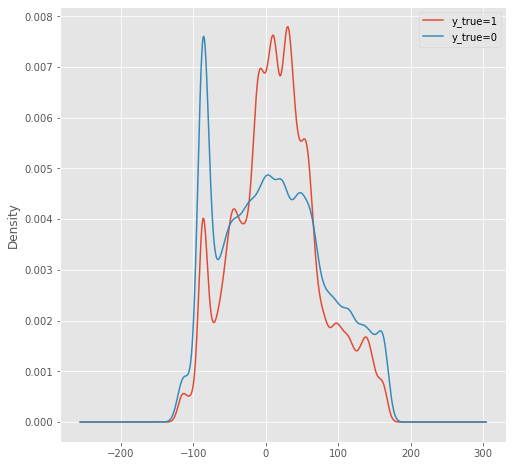

In [75]:
plt.figure(figsize=(8, 8))
wv_sum_dc1[wv_sum_dc1['y_true']==1].dc0.plot.density(bw_method=0.1)
wv_sum_dc1[wv_sum_dc1['y_true']==0].dc0.plot.density(bw_method=0.1)
plt.legend(['y_true=1', 'y_true=0'])

<AxesSubplot:xlabel='dc0', ylabel='dc1'>

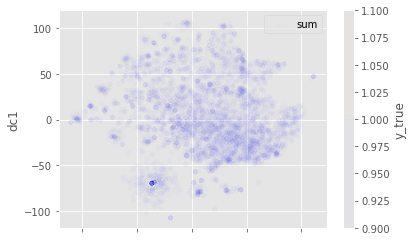

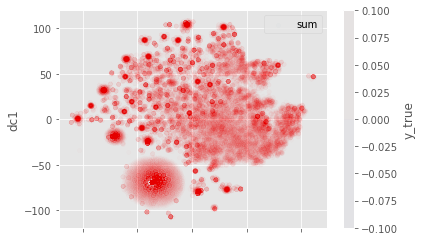

In [58]:
wv_sum_dc2[wv_sum_dc2.y_true==1].plot.scatter(x='dc0', y='dc1', alpha=0.01, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))
wv_sum_dc2[wv_sum_dc2.y_true==0].plot.scatter(x='dc0', y='dc1', alpha=0.01, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))

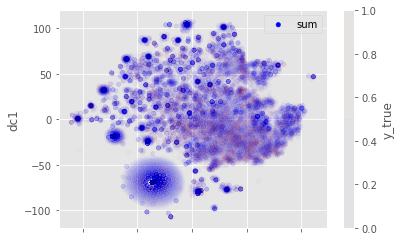

In [59]:
wv_sum_dc2.plot.scatter(x='dc0', y='dc1', alpha=.01, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ICA


<AxesSubplot:xlabel='dc0', ylabel='dc1'>

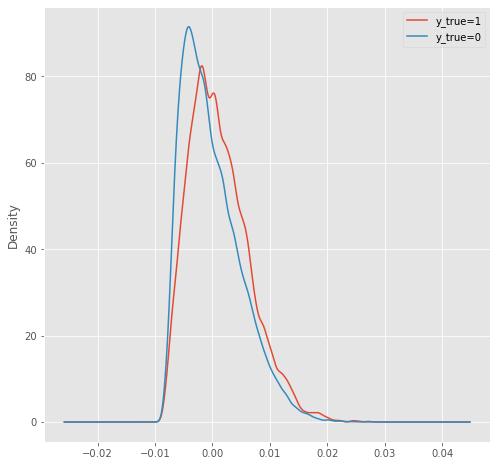

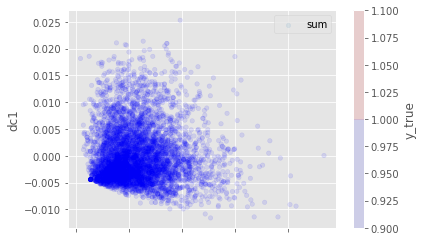

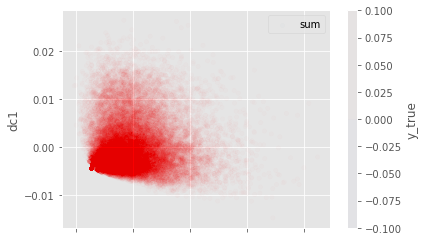

In [56]:
ica_dc1 = FastICA(n_components=1)
ica_dc2 = FastICA(n_components=2)
#dc_result_mean = dc.fit_transform(wv_mean.iloc[:, 2:])
ica_dc1_result_sum = ica_dc1.fit_transform(wv_sum.iloc[:, 2:])
ica_dc2_result_sum = ica_dc2.fit_transform(wv_sum.iloc[:, 2:])

#df_mean = pd.DataFrame(dc_result_mean, columns=['dc0', 'dc1'])
ica_df_sum_dc1 = pd.DataFrame(ica_dc1_result_sum, columns=['dc0'])
ica_df_sum_dc2 = pd.DataFrame(ica_dc2_result_sum, columns=['dc0', 'dc1'])
#wv_mean_dc = pd.concat([wv_mean, df_mean], axis=1)
wv_sum_ica_dc1 = pd.concat([wv_sum, ica_df_sum_dc1], axis=1)
wv_sum_ica_dc2 = pd.concat([wv_sum, ica_df_sum_dc2], axis=1)

plt.figure(figsize=(8, 8))
wv_sum_ica_dc1[wv_sum_ica_dc1['y_true']==1].dc0.plot.density(bw_method=0.1)
wv_sum_ica_dc1[wv_sum_ica_dc1['y_true']==0].dc0.plot.density(bw_method=0.1)
plt.legend(['y_true=1', 'y_true=0'])

wv_sum_ica_dc2[wv_sum_ica_dc2.y_true==1].plot.scatter(x='dc0', y='dc1', alpha=0.1, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))
wv_sum_ica_dc2[wv_sum_ica_dc2.y_true==0].plot.scatter(x='dc0', y='dc1', alpha=0.01, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))

<AxesSubplot:xlabel='dc0', ylabel='dc1'>

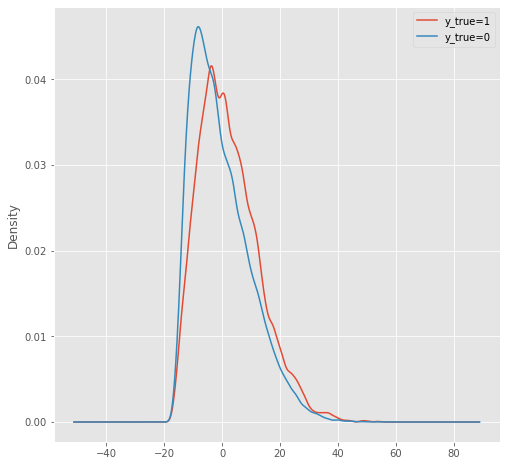

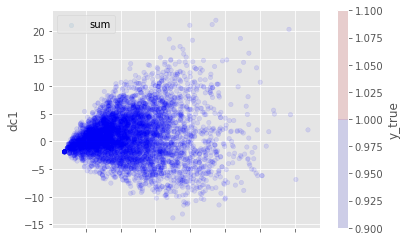

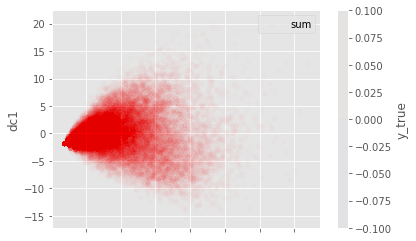

In [57]:
pca_dc1 = PCA(n_components=1)
pca_dc2 = PCA(n_components=2)
#dc_result_mean = dc.fit_transform(wv_mean.iloc[:, 2:])
pca_dc1_result_sum = pca_dc1.fit_transform(wv_sum.iloc[:, 2:])
pca_dc2_result_sum = pca_dc2.fit_transform(wv_sum.iloc[:, 2:])

#df_mean = pd.DataFrame(dc_result_mean, columns=['dc0', 'dc1'])
pca_df_sum_dc1 = pd.DataFrame(pca_dc1_result_sum, columns=['dc0'])
pca_df_sum_dc2 = pd.DataFrame(pca_dc2_result_sum, columns=['dc0', 'dc1'])
#wv_mean_dc = pd.concat([wv_mean, df_mean], axis=1)
wv_sum_pca_dc1 = pd.concat([wv_sum, pca_df_sum_dc1], axis=1)
wv_sum_pca_dc2 = pd.concat([wv_sum, pca_df_sum_dc2], axis=1)

plt.figure(figsize=(8, 8))
wv_sum_pca_dc1[wv_sum_pca_dc1['y_true']==1].dc0.plot.density(bw_method=0.1)
wv_sum_pca_dc1[wv_sum_pca_dc1['y_true']==0].dc0.plot.density(bw_method=0.1)
plt.legend(['y_true=1', 'y_true=0'])

wv_sum_pca_dc2[wv_sum_pca_dc2.y_true==1].plot.scatter(x='dc0', y='dc1', alpha=0.1, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))
wv_sum_pca_dc2[wv_sum_pca_dc2.y_true==0].plot.scatter(x='dc0', y='dc1', alpha=0.01, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))

In [43]:
wv = k_result_df[['k900_sum_wv', 'ICUSTAY_ID']]
wv.merge(listfile_df, how='inner', on='ICUSTAY_ID')
wv = wv.merge(listfile_df, how='inner', on='ICUSTAY_ID')
#wv['k200_mean_wv'] = wv['k200_mean_wv'].apply(lambda r: np.zeros(200) if r.size == 1 else r)
wv['k900_sum_wv'] = wv['k900_sum_wv'].apply(lambda r: np.zeros(200) if r.size == 1 else r)

#mean_v = pd.DataFrame(list(wv.k200_mean_wv))
sum_v = pd.DataFrame(list(wv.k900_sum_wv))

#wv_mean = pd.concat([wv[['ICUSTAY_ID', 'y_true']], mean_v], axis=1)
wv_sum = pd.concat([wv[['ICUSTAY_ID', 'y_true']], sum_v], axis=1)

ss = StandardScaler()
#wv_mean.iloc[:, 2:] = ss.fit_transform(wv_mean.iloc[:, 2:])
wv_sum.iloc[:, 2:] = ss.fit_transform(wv_sum.iloc[:, 2:])

<AxesSubplot:xlabel='dc0', ylabel='dc1'>

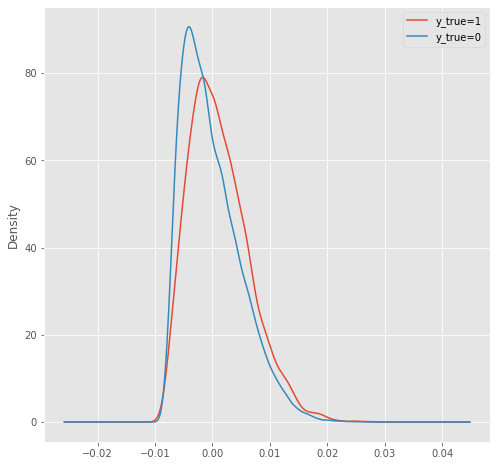

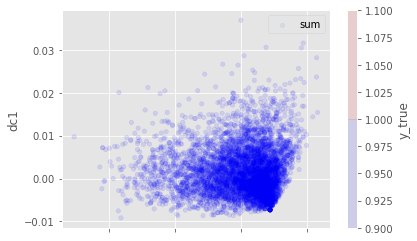

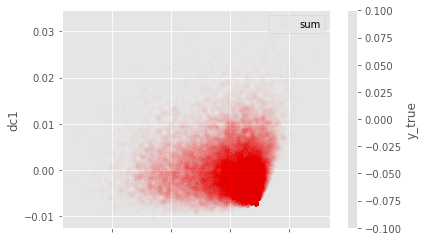

In [44]:
ica_dc1 = FastICA(n_components=1)
ica_dc2 = FastICA(n_components=2)
#dc_result_mean = dc.fit_transform(wv_mean.iloc[:, 2:])
ica_dc1_result_sum = ica_dc1.fit_transform(wv_sum.iloc[:, 2:])
ica_dc2_result_sum = ica_dc2.fit_transform(wv_sum.iloc[:, 2:])

#df_mean = pd.DataFrame(dc_result_mean, columns=['dc0', 'dc1'])
ica_df_sum_dc1 = pd.DataFrame(ica_dc1_result_sum, columns=['dc0'])
ica_df_sum_dc2 = pd.DataFrame(ica_dc2_result_sum, columns=['dc0', 'dc1'])
#wv_mean_dc = pd.concat([wv_mean, df_mean], axis=1)
wv_sum_ica_dc1 = pd.concat([wv_sum, ica_df_sum_dc1], axis=1)
wv_sum_ica_dc2 = pd.concat([wv_sum, ica_df_sum_dc2], axis=1)

plt.figure(figsize=(8, 8))
wv_sum_ica_dc1[wv_sum_ica_dc1['y_true']==1].dc0.plot.density()
wv_sum_ica_dc1[wv_sum_ica_dc1['y_true']==0].dc0.plot.density()
plt.legend(['y_true=1', 'y_true=0'])

wv_sum_ica_dc2[wv_sum_ica_dc2.y_true==1].plot.scatter(x='dc0', y='dc1', alpha=0.1, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))
wv_sum_ica_dc2[wv_sum_ica_dc2.y_true==0].plot.scatter(x='dc0', y='dc1', alpha=0.01, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))

<AxesSubplot:xlabel='dc0', ylabel='dc1'>

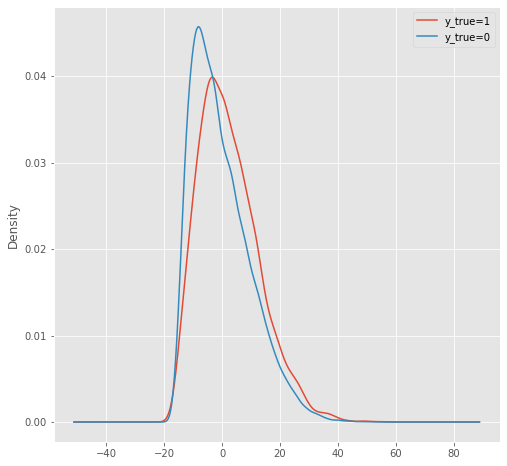

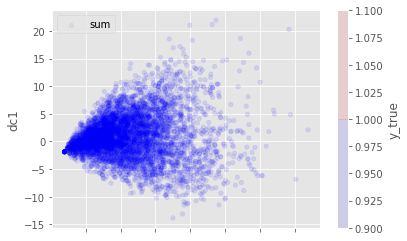

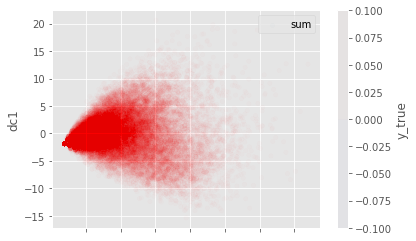

In [45]:
pca_dc1 = PCA(n_components=1)
pca_dc2 = PCA(n_components=2)
#dc_result_mean = dc.fit_transform(wv_mean.iloc[:, 2:])
pca_dc1_result_sum = pca_dc1.fit_transform(wv_sum.iloc[:, 2:])
pca_dc2_result_sum = pca_dc2.fit_transform(wv_sum.iloc[:, 2:])

#df_mean = pd.DataFrame(dc_result_mean, columns=['dc0', 'dc1'])
pca_df_sum_dc1 = pd.DataFrame(pca_dc1_result_sum, columns=['dc0'])
pca_df_sum_dc2 = pd.DataFrame(pca_dc2_result_sum, columns=['dc0', 'dc1'])
#wv_mean_dc = pd.concat([wv_mean, df_mean], axis=1)
wv_sum_pca_dc1 = pd.concat([wv_sum, pca_df_sum_dc1], axis=1)
wv_sum_pca_dc2 = pd.concat([wv_sum, pca_df_sum_dc2], axis=1)

plt.figure(figsize=(8, 8))
wv_sum_pca_dc1[wv_sum_pca_dc1['y_true']==1].dc0.plot.density()
wv_sum_pca_dc1[wv_sum_pca_dc1['y_true']==0].dc0.plot.density()
plt.legend(['y_true=1', 'y_true=0'])

wv_sum_pca_dc2[wv_sum_pca_dc2.y_true==1].plot.scatter(x='dc0', y='dc1', alpha=0.1, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))
wv_sum_pca_dc2[wv_sum_pca_dc2.y_true==0].plot.scatter(x='dc0', y='dc1', alpha=0.01, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))

<AxesSubplot:xlabel='dc0', ylabel='dc1'>

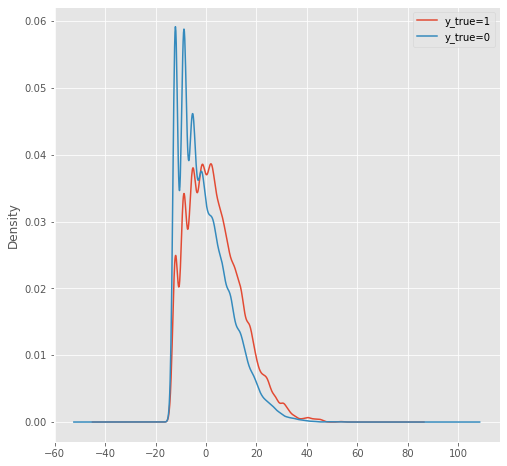

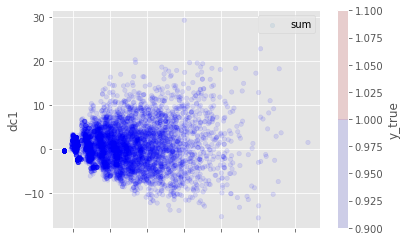

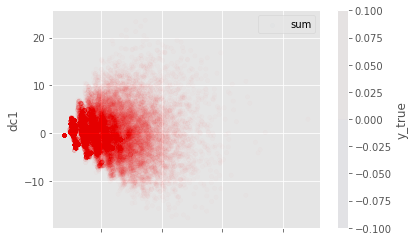

In [18]:
wv = k_result_df[['k200_sum_wv', 'ICUSTAY_ID']]
wv.merge(listfile_df, how='inner', on='ICUSTAY_ID')
wv = wv.merge(listfile_df, how='inner', on='ICUSTAY_ID')
#wv['k200_mean_wv'] = wv['k200_mean_wv'].apply(lambda r: np.zeros(200) if r.size == 1 else r)
wv['k200_sum_wv'] = wv['k200_sum_wv'].apply(lambda r: np.zeros(200) if r.size == 1 else r)

#mean_v = pd.DataFrame(list(wv.k200_mean_wv))
sum_v = pd.DataFrame(list(wv.k200_sum_wv))

#wv_mean = pd.concat([wv[['ICUSTAY_ID', 'y_true']], mean_v], axis=1)
wv_sum = pd.concat([wv[['ICUSTAY_ID', 'y_true']], sum_v], axis=1)

ss = StandardScaler()
#wv_mean.iloc[:, 2:] = ss.fit_transform(wv_mean.iloc[:, 2:])
wv_sum.iloc[:, 2:] = ss.fit_transform(wv_sum.iloc[:, 2:])

from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import TSNE
dc1 = PCA(n_components=1)
dc2 = PCA(n_components=2)
#dc_result_mean = dc.fit_transform(wv_mean.iloc[:, 2:])
dc1_result_sum = dc1.fit_transform(wv_sum.iloc[:, 2:])
dc2_result_sum = dc2.fit_transform(wv_sum.iloc[:, 2:])

#df_mean = pd.DataFrame(dc_result_mean, columns=['dc0', 'dc1'])
df_sum_dc1 = pd.DataFrame(dc1_result_sum, columns=['dc0'])
df_sum_dc2 = pd.DataFrame(dc2_result_sum, columns=['dc0', 'dc1'])
#wv_mean_dc = pd.concat([wv_mean, df_mean], axis=1)
wv_sum_dc1 = pd.concat([wv_sum, df_sum_dc1], axis=1)
wv_sum_dc2 = pd.concat([wv_sum, df_sum_dc2], axis=1)

plt.figure(figsize=(8, 8))
wv_sum_dc1[wv_sum_dc1['y_true']==1].dc0.plot.density(bw_method=0.1)
wv_sum_dc1[wv_sum_dc1['y_true']==0].dc0.plot.density(bw_method=0.1)
plt.legend(['y_true=1', 'y_true=0'])

wv_sum_dc2[wv_sum_dc2.y_true==1].plot.scatter(x='dc0', y='dc1', alpha=0.1, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))
wv_sum_dc2[wv_sum_dc2.y_true==0].plot.scatter(x='dc0', y='dc1', alpha=0.01, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))

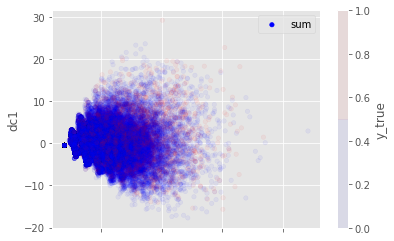

In [19]:
wv_sum_dc2.plot.scatter(x='dc0', y='dc1', alpha=.05, label='sum', c='y_true', cmap=colors.ListedColormap(['blue', 'red']))
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = KFold(n_splits=2)
cat_boost = CatBoostClassifier()
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X, y)
    
y_pred = model.predict()

.decision_function(X_test)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
cat_boost = CatBoostClassifier()

cat_boost.fit(X, y)
    
y_pred = cat_boost.predict(X)
y_decision = cat_boost.decision_function(X)

#.decision_function(X_test)
roc_auc_score()

In [ ]:
with open('/home/mimic/Data/pickle/wv_sum_dc1_900.pk', 'wb') as f:
    pickle.dump(wv_sum_dc1, f, pickle.HIGHEST_PROTOCOL)
with open('/home/mimic/Data/pickle/wv_sum_dc2_900.pk', 'wb') as f:
    pickle.dump(wv_sum_dc2, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
roc_auc_score

In [212]:
np.mean(result_df['word_list'].apply(lambda l: len(l))), \
np.mean(result_df['k200_list'].apply(lambda l: len(l))), \
np.mean(result_df['k300_list'].apply(lambda l: len(l))), \
np.mean(result_df['k400_list'].apply(lambda l: len(l))), \
np.mean(result_df['k500_list'].apply(lambda l: len(l))), \
np.mean(result_df['k600_list'].apply(lambda l: len(l))), \
np.mean(result_df['k900_list'].apply(lambda l: len(l)))

(57.75263947763355,
 3.589347305231563,
 5.178984228956583,
 7.133040204312683,
 9.071720070561597,
 9.190753271372529,
 10.839340722993075)

In [213]:
np.mean(result_df['word_list'].apply(lambda l: len(l)) == 0), \
np.mean(result_df['k200_list'].apply(lambda l: len(l)) == 0), \
np.mean(result_df['k300_list'].apply(lambda l: len(l)) == 0), \
np.mean(result_df['k400_list'].apply(lambda l: len(l)) == 0), \
np.mean(result_df['k500_list'].apply(lambda l: len(l)) == 0), \
np.mean(result_df['k600_list'].apply(lambda l: len(l)) == 0), \
np.mean(result_df['k900_list'].apply(lambda l: len(l)) == 0)

(0.00018430267765461679,
 0.12980174297675154,
 0.04818198572970696,
 0.0218003738711461,
 0.009583739238040073,
 0.009346778652484136,
 0.006213633132355651)

In [232]:
k_result_df.head(50)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,TEXT,word_list,mean_wv,sum_wv,k200_list,k200_mean_wv,k200_sum_wv,...,k400_sum_wv,k500_list,k500_mean_wv,k500_sum_wv,k600_list,k600_mean_wv,k600_sum_wv,k900_list,k900_mean_wv,k900_sum_wv
0,3,145834.0,211552,Admission Date: [**2101-10-20**] Discharg...,"{ascorbic acid, gastrointestinal bleed, hospit...","[0.320220878461794, 0.03231701895366518, -0.28...","[15.690823044627905, 1.5835339287295938, -14.0...","{ulcers, tachycardia, wheezing, hypoxia, hypot...","[0.01767680738121271, 0.2923035994172096, -0.2...","[0.08838403690606356, 1.4615179970860481, -1.4...",...,"[3.74537402857095, -0.18190199881792068, -3.52...","{ulcers, tachycardia, wheezing, metronidazole,...","[0.31337650236673653, 0.050148998076717057, -0...","[3.7605180284008384, 0.6017879769206047, -3.63...","{ulcers, tachycardia, wheezing, metronidazole,...","[0.24327677137290055, 0.058501382859853596, -0...","[3.1625980278477073, 0.7605179771780968, -3.47...","{ulcers, tachycardia, wheezing, pertinent, pai...","[0.03302289100570811, 0.4581264439556334, -0.2...","[0.297206019051373, 4.1231379956007, -1.971277..."
1,4,185777.0,294638,Admission Date: [**2191-3-16**] Discharge...,"{allergies, toxic metabolic disease, clindamyc...","[0.21231900266296155, 0.11549778116514554, -0....","[7.855803098529577, 4.273417903110385, -3.2465...","{pneumonia, dyspnea, fevers}","[-0.23553532672425112, 0.36155834297339123, -0...","[-0.7066059801727533, 1.0846750289201736, -0.3...",...,"[1.1578240003436804, 1.0817049741744995, -1.32...","{dyspnea, nausea, fluconazole, tuberculosis, f...","[0.2055454987566918, 0.11993937194347382, -0.1...","[1.6443639900535345, 0.9595149755477905, -1.26...","{dyspnea, nausea, fluconazole, tuberculosis, f...","[0.2055454987566918, 0.11993937194347382, -0.1...","[1.6443639900535345, 0.9595149755477905, -1.26...","{dyspnea, fibrosis, pertinent, chills, myalgia...","[-0.019724899530410768, 0.40210759863257406, -...","[-0.19724899530410767, 4.021075986325741, -0.5..."
2,12,112213.0,232669,Admission Date: [**2104-8-7**] Discharge ...,"{agitation, blood loss, clubbing, mesenteric b...","[0.17977227432032425, 0.3296726663907369, -0.3...","[2.696584114804864, 4.9450899958610535, -4.579...","{jaundiced, asystolic}","[0.02341499924659729, 0.3518749997019768, -0.4...","[0.04682999849319458, 0.7037499994039536, -0.8...",...,"[-0.29760000109672546, 0.5497799962759018, -1....","{jaundiced, asystolic, haldol, hypertension, e...","[-0.20152320079505442, 0.34668799340724943, -0...","[-1.0076160039752722, 1.7334399670362473, -2.4...","{jaundiced, asystolic, haldol, hypertension, e...","[-0.20152320079505442, 0.34668799340724943, -0...","[-1.0076160039752722, 1.7334399670362473, -2.4...","{jaundiced, agitation, asystolic, clubbing, ly...","[-0.055894281182970317, 0.3982514334576471, -0...","[-0.39125996828079224, 2.7877600342035294, -2...."
3,13,143045.0,263738,Admission Date: [**2167-1-8**] Discharg...,"{hyperlipidemia, captopril, hospital1, neo-syn...","[0.33918255337170866, 0.19825733437104837, -0....","[12.888937028124928, 7.533778706099838, -13.23...","{hyperglycemia, infarction}","[0.3652215115725994, 0.5080300122499466, -0.34...","[0.7304430231451988, 1.0160600244998932, -0.68...",...,"[1.8258430287241936, 2.0071000307798386, -1.56...","{nausea, hypertension, hyperglycemia, nitrogly...","[0.30683117142568034, 0.46513166775306064, -0....","[1.840987028554082, 2.790790006518364, -1.6677...","{nausea, hypertension, hyperglycemia, nitrogly...","[0.30683117142568034, 0.46513166775306064, -0....","[1.840987028554082, 2.790790006518364, -1.6677...","{constipation, hyperlipidemia, pain, tumor, hy...","[0.463724123314023, 0.5536699965596199, -0.174...","[3.709792986512184, 4.429359972476959, -1.3960..."
4,17,161087.0,257980,Admission Date: [**2135-5-9**] D...,"{bactrim, allergies, cervical disc herniation,...","[-0.0037960425357926974, 0.27882304292341525, ...","[-0.08351293578743935, 6.1341069443151355, -3....","{hypotensive, hypotension}","[-0.62

In [12]:
icustay_id = 246806
icustay_info = k_result_df[k_result_df['ICUSTAY_ID'] == icustay_id]
icustay_text = icustay_info['TEXT'].values[0]
icustay_k200_list = icustay_info['k200_list'].values[0]
nlp_result = nlp_model(icustay_text)

# Select only keyword in k200_list
ents_list = list(nlp_result.ents)
for ent in ents_list[:]:
    ent_str = str(ent.ents[0])
    if ent_str not in icustay_k200_list:
        ents_list.remove(ent)
        
nlp_result.ents = tuple(ents_list)
displacy_image = displacy.render(nlp_result, jupyter = True, style = 'ent',
                                 options = {'ents': ['DISEASE', 'CHEMICAL'],
                                                  'colors': {'DISEASE': '#F08080',
                                                                'CHEMICAL': '#87CEEB'}})

In [ ]:
>>> kf.get_n_splits(X)
2
>>> print(kf)
KFold(n_splits=2, random_state=None, shuffle=False)
>>> for train_index, test_index in kf.split(X):
...     print("TRAIN:", train_index, "TEST:", test_index)
...     X_train, X_test = X[train_index], X[test_index]
...     y_train, y_test = y[train_index], y[test_index]
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]